![](https://www.math.unipd.it/~marcuzzi/BannerStrumentifondamentali.png)


# Metodi iterativi
Spesso i sistemi lineari la cui matrice è sparsa non sono risolti con la decomposizione LU, ma vengono utilizzati dei metodi che, partendo da un certo punto iniziale, si avvicinano per approssimazioni successive alla soluzione del sistema. Questi metodi sono noti come metodi iterarivi, e uno dei più diffusi nel caso di matrici simmetriche e definite positive è il **gradiente coniugato**.

## Il gradiente coniugato

Vogliamo calcolare la soluzione del sistema lineare
$$ Ax = b, $$
dove la matrice $A$ è quadrata, simmetrica e definita posiva.
Notiamo che possiamo definire il seguente prodotto interno
$$ \langle u,v \rangle_A = u^TAv, \quad \forall u,v \in \mathbb{R}^n.$$

Se $u,v$ sono tali che $ \langle u,v \rangle_A = 0$, allora si dicono $A$-coniugati. Notiamo inolte che la soluzione del sistema $Ax = b$ deve essere l'unico punto di minimo della sequente forma quadratica
$$ Q(x) = x^TAx - x^Tb, $$
perchè
$$ \nabla Q(x) = 0 \Leftrightarrow Ax-b=0.$$
Questo suggetisce che una soluzione può essere trovata iterativamente partendo da un punto $x_0$ e procedendo lungo oppurtune direzioni $\left\{ p_k \right\}$. Dette $\left\{ x_k \right\}$ le iterate, le direzioni per la forma quadratica $Q$ sono date dai residui
$$ r_k = -\nabla Q(x) = b-Ax_k.$$
Il metodo dei gradiente prende $p_k = r_k$, nel metodo del gradiente coniugato invece scegliamo direzioni $p_k$ che siano tra loro $A$-coniugate, perciò scegliamo
$$ p_{k} = r_{k} + \frac{r_{k}^Tr_{k}}{r_{k-1}^Tr_{k-1}}p_{k-1} $$
e lungo questa direzione scegliamo
$$ x_{k+1} = x_k+\alpha_k p_k, \quad \alpha_k = \frac{r_k^Tr_k}{p_k^TAp_k}. $$

La ricerca termina quando l'errore sulla soluzione raggiunge una certa soglia di tolleranza, oppure quando viene raggiunto il numero massimo di iterazioni.

L'implementazione seriale è immediata partendo da un qualsiasi speudocodice reperibile online, ad esempio si veda il codice matlab https://www.netlib.org/templates/matlab//cg.m.

In [1]:
import numpy as np
from numba import cuda
import numba
from scipy.io import mmread
import scipy
import scipy.sparse.linalg as sla

import matplotlib.pyplot as plt
import math
from timeit import default_timer

In [2]:
import pyculib.blas as blas
import pyculib.sparse as sparse

In [3]:
cusparseH = sparse.Sparse()
cublasH = blas.Blas()

In [4]:
def cg_cpu(A, b, x = None, max_it = None, tol = 1e-5):
    nnz = A.nnz
    m,n = A.shape
    if (m != n):
        print("Errore: la matrice non e' quadrata")
        return
    
    if (max_it == None):
        max_it = 10*n
    if (x == None):
        x = np.zeros((n,))
    #endif
    
    flag = 0
    iters = 0

    bnrm2 = np.linalg.norm(b)
    
    if  ( bnrm2 == 0.0 ): 
        bnrm2 = 1.0
    #endif

    r = b - A.dot(x)

    error = np.linalg.norm(r) / bnrm2
    if ( error < tol ):
        return

    for iters in range(max_it):     
        rho = np.linalg.norm(r)
        rho = rho*rho

        if ( iters > 0 ): #direzione di discesa
            beta = rho / rho_1
            p = r + beta*p
        else:
            p = r.copy()
        #endif

        q = A.dot(p)
        
        #aggiono la soluzione
        alpha = rho / np.dot(p,q)
        x = alpha*p + x
        
        #calcolo il residuo
        r = -alpha*q + r

        #controllo la convergenza
        error = np.linalg.norm(r) / bnrm2 
        if ( error <= tol ): 
            break
        #endif
        rho_1 = rho
    #endfor
    
    if ( error > tol ):
        flag = 1 # no convergenza
    #endif
    
    return x, error, iters, flag

In [5]:
def cg_gpu(A, b, x = None, max_it = None, tol = 1e-5):
    nnz = A.nnz
    m,n = A.shape
    if (m != n):
        print("Errore: la matrice non e' quadrata")
        return
    
    dtype  = A.dtype
    one    = dtype.type(1.0)
    oneopp = dtype.type(-1.0)
    zero   = dtype.type(0.0)
    r = cuda.device_array((n,), dtype=dtype)
    p = cuda.device_array((n,), dtype=dtype)
    q = cuda.device_array((n,), dtype=dtype)
    
    descrA = cusparseH.matdescr(matrixtype = 'S')
    
    if (max_it == None):
        max_it = 10*n
    if (x == None):
        x = cuda.to_device(np.zeros((n,), dtype=dtype,order='F'))
    #endif
    
    flag = 0
    iters = 0
    rho_1 = 0.0

    bnrm2 = cublasH.nrm2(b)
    
    if  ( bnrm2 == 0.0 ): 
        bnrm2 = 1.0

    # r = b - A*x
    r.copy_to_device(b)
    cusparseH.csrmv('N', n, n, nnz, oneopp, descrA, A.data, A.indptr, A.indices, x, one, r)

    error = np.linalg.norm(r) / bnrm2
    if ( error < tol ):
        return
    
    for iters in range(max_it):  
        #rho = np.dot(r,r)
        rho = cublasH.nrm2(r)
        rho = rho*rho

        if ( iters > 0 ): #direzione di discesa
            # p = r + beta*p
            beta = rho / rho_1
            cublasH.scal(beta, p)
            cublasH.axpy(one, r, p)

        else:
            p.copy_to_device(r)
        #end
        
        #q = A.dot(p)
        cusparseH.csrmv('N', n, n, nnz, one, descrA, A.data, A.indptr, A.indices, p, zero, q)
        
        #aggiono la soluzione
        alpha = rho / cublasH.dot(p,q)
        cublasH.axpy(alpha, p, x)

        #calcolo il residuo
        cublasH.axpy( dtype.type(alpha*(-1.0)), q, r)

        #controllo la convergenza
        error = cublasH.nrm2(r) / bnrm2 
        
        if ( error <= tol ): 
            break
        #endif
        rho_1 = rho
    #endfor

    if ( error > tol ):
        flag = 1 # no convergenza
    #endif
        
    return x, error, iters, flag

In [6]:
# importiamo la matrice test e generiamo il membro destro
cartella = './matrici_test/'
A = mmread(cartella+'sts4098.mtx').tocsr()
b = np.random.random((A.shape[0],))

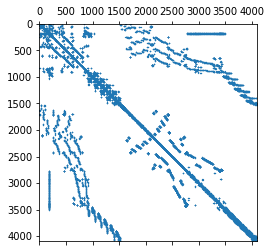

In [7]:
plt.spy(A, markersize = 0.2)

In [8]:
#trasferimento host -> device
d_A = sparse.csr_matrix((A.data, A.indices, A.indptr))#scipy.sparse.tril(A).tocsr())
d_b = cuda.to_device(b)

In [9]:
d_x, error, iters, flag = cg_gpu(d_A, d_b)

In [10]:
print('iterazioni necessarie alla convergenza :', iters)

iterazioni necessarie alla convergenza : 25904


In [11]:
x_gpu = d_x.copy_to_host()
print('||Ax - b|| = ', np.linalg.norm(A*x_gpu-b))

||Ax - b|| =  0.0003548150496773293


In [12]:
x_cpu, error, iters, flag = cg_cpu(A, b)

In [13]:
print('iterazioni necessarie alla convergenza :', iters)

iterazioni necessarie alla convergenza : 26060


In [14]:
print('||Ax - b|| = ', np.linalg.norm(A*x_cpu-b))

||Ax - b|| =  0.00036294204142443186


## Il numero di condizionamento

Abbiamo già incontrato il numero di condizionamento di una matrice nella prima settimana del corso. Il numero di condizionamento esprime quando sono sensibili le soluzioni a piccole perturbazioni dei dati iniziali. Questo concetto è molto importante in generale, infatti un sistema mal condizionato tende ad amplificare anche l'errore (il rumore sui dati) contenuto nel termine noto. Matematicamente esso si esprime come il rapporto tra il valore singolare più grande e quello più piccolo della matrice, cioè

$$ \kappa(A) = \frac{\sigma_1}{\sigma_n}. $$

Una matrice è quindi malcondizionata quando il valore singolare più piccolo è molto vicino allo zero, o quando il gap tra i valori singolari è molto grande.
Il numero di condizionamento si può esprimere anche in termini di autovalori, infatti 

$$ \kappa(A) = \sqrt{\frac{\lambda_1(A^TA)}{\lambda_n(A^TA)}}, $$

dove $\lambda_1, \lambda_n$ sono rispettivamente l'autovalore piu grande e piu piccolo della matrice $A^T A$.

Il numero di condizionamento è uno dei fattori principali che influenza in numero di iterazioni necessarie alla convergenza di un metodo iterativo. Tuttavia la routine `numpy.linalg.cond` non è applicabile nel caso delle matrici sparse per ragioni di memoria. Nel caso di matrici sparse e di grandi dimensioni è preferibile calcolare gli autovalori della matrice $A^TA$. Per farlo utilizziamo la routine `scipy.sparse.linalg.eigs` che permette di calcolare autovalori e autovettori
- la keywork `k` specifica il numero di autovalori e autovettori desiderati;
- la keyword `which` specifica quali $k$ autovalori cercare, ad es. `which = 'LM'` specifica di trovare gli autovalori di norma più grande (LM = Largest Magnitude), `which = 'SM'` specifica di trovare gli autovalori di norma più piccola (SM = Smallest Magnitude), ecc... tuttavia non è consigliabile l'utilizzo di `which = 'SM'` per trovare gli autovalori più piccoli, infatti in questo caso la routine diventa molto lenta;
- piuttosto, la keyword `sigma` permette di calcolare gli autovalori più piccoli in maniera più efficiente, utilizzando una modalità nota come *shift-invert*. Per trovare gli autovalori di norma vicina allo zero è sufficiente porre `sigma=0`.

In [15]:
ATA = A.T*A
l_1, v = sla.eigs(ATA, k = 1)
l_n, v = sla.eigs(ATA, k = 1, sigma = 0)

In [16]:
kA = math.sqrt(l_1[0].real/l_n[0].real)
print('k(A) = %e'%kA)

k(A) = 2.170866e+08


## Il precondizionamento
Abbiamo accennato a come il numero di iterazioni necessario alla convergenza di un metodo iterativo dipenda dal nomero di condizionamento della matrice. Da questa necessità di migliorare il numero di condizionamento nasce l'idea di precondizionamento. Un precondizionatore (propriamente un precondizionatore sinistro) è una matrice $M$ che premoltiplica il sistema $Ax=b$. Poi, invece di risolvere il sistema originale, andiamo a risolvere il sistema equivalente

$$ MAx = Mb. $$

Idealmente, scegliamo il precondizionatore in maniera tale che $MA \approx I$, più in generale chiediamo che il numero di condizionamento del nuovo sistema $\kappa(MA)$ sia più basso del numero di condizionamento del sistema originale $\kappa(A)$.

In generale, la scelta del precondizionatore è un problema molto complesso. Qui ci limitiamo a vedere una delle tecniche di precondizionamento più semplici, il precondizionatore diagonale. Scegliamo quindi $M=diag(A)^{-1}$. In questo caso l'applicazione del precondizionatore consiste in un prodotto matrice vettore, che è un'operazione ben parallelizzabile.

In [17]:
def pcg_gpu(A, b, M, x = None, max_it = None, tol = 1e-5):
    nnz = A.nnz
    m,n = A.shape
    if (m != n):
        print("Errore: la matrice non e' quadrata")
        return
    
    dtype  = A.dtype
    one    = dtype.type(1.0)
    oneopp = dtype.type(-1.0)
    zero   = dtype.type(0.0)
    
    descrA = cusparseH.matdescr(matrixtype = 'G')
    
    if (max_it == None):
        max_it = 10*n
    if (x == None):
        x = cuda.to_device(np.zeros((n,), dtype=dtype,order='F'))
    #endif
    r = cuda.device_array((n,), dtype=dtype)
    z = cuda.device_array((n,), dtype=dtype)
    p = cuda.device_array((n,), dtype=dtype)
    q = cuda.device_array((n,), dtype=dtype)
    
    flag = 0
    iters = 0
    rho_1 = 0.0

    bnrm2 = cublasH.nrm2(b)
    
    if  ( bnrm2 == 0.0 ): 
        bnrm2 = 1.0

    # r =b - A*x
    r.copy_to_device(b)
    
    cusparseH.csrmv('N', n, n, nnz, oneopp, descrA, A.data, A.indptr, A.indices, x, one, r)

    error = np.linalg.norm(r) / bnrm2
    if ( error < tol ):
        return
    
    for iters in range(max_it):  
        #applico il precondizionatore: z = M * r
        cusparseH.csrmv('N', n, n, M.nnz, one, descrA, M.data, M.indptr, M.indices, r, zero, z)
        
        rho = cublasH.dot(z,r)
        

        if ( iters > 0 ): #direzione di discesa
            # p = z + beta*p
            beta = rho / rho_1
            cublasH.scal(beta, p)
            cublasH.axpy(one, z, p)

        else:
            p.copy_to_device(z)
        #end

        
        #q = A.dot(p)
        cusparseH.csrmv('N', n, n, nnz, one, descrA, A.data, A.indptr, A.indices, p, zero, q)
        
        #aggiono la soluzione
        alpha = rho / cublasH.dot(p,q)
        cublasH.axpy(alpha, p, x)

        #calcolo il residuo
        cublasH.axpy( dtype.type(alpha*(-1.0)), q, r)

        #controllo la convergenza
        error = cublasH.nrm2(r) / bnrm2 
        
        if ( error <= tol ): 
            break
        #endif
        rho_1 = rho
    #endfor

    if ( error > tol ):
        flag = 1 # no convergenza
    #endif
        
    return x, error, iters, flag

In [18]:
#calcolo del precondizionatore
D = np.reciprocal(A.diagonal())
D = scipy.sparse.diags([D], [0]).tocsr()
d_D = sparse.csr_matrix((D.data, D.indices, D.indptr))

In [19]:
d_x, error, iters, flag = pcg_gpu(d_A, d_b, d_D)

In [20]:
print('iterazioni necessarie alla convergenza :', iters)

iterazioni necessarie alla convergenza : 361


In [21]:
x_gpu = d_x.copy_to_host()
print('||Ax - b|| = ', np.linalg.norm(A*x_cpu-b))

||Ax - b|| =  0.00036294204142443186


In [22]:
del d_A, d_b, d_x

In [23]:
DA = D*A
M = (DA.T)*DA
l_1, v = sla.eigs(M, k = 1)
l_n, v = sla.eigs(M, k = 1, sigma = 0)

In [24]:
kMA = math.sqrt(l_1[0].real/l_n[0].real)
print('k(MA) = %e'%kMA)

k(MA) = 7.518683e+06
